# Importing Libraries

In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import pickle
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf

# Feature Extraction for Speech Emotion Recognition|

In [2]:
# Emotions in the RAVDESS dataset
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

def extract_feature(data, sr, mfcc, chroma, mel):
    """
    Extract features from audio files into numpy array
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency
    
    """
    if chroma:
        stft = np.abs(librosa.stft(data))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
        mel = np.mean(mel_spectrogram.T, axis=0)
        result = np.hstack((result, mel))
        
    return result


# Adding Noise to Audio for Data Augmentation

In [3]:
def noise(data, noise_factor):
    """
    Add random white noise to the audio
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added
    
    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data


# Shifting Audio Spectrogram for Data Augmentation

In [4]:
def shift(data, sampling_rate, shift_max, shift_direction):
    """
    Shift the spectrogram in a direction
    
    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both
    
    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

# Loading and Augmenting Speech Data for Emotion Recognition

In [5]:
def load_data(data_directory, save=False):
    """
    Load dataset
    
    Parameters
    ----------
    data_directory : string, path to the dataset
    save : boolean, save the data to disk as .npy
    
    """
    x, y = [], []
    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        data, sr = librosa.load(file)
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        y.append(emotion)
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)
        s_data = shift(data, sr, 0.25, 'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)
    if save:
        np.save('X', np.array(x))
        np.save('y', y)
    return np.array(x), y


# Loading, Splitting, and Preprocessing the Speech Emotion Dataset

In [7]:
# Define the dataset path
data_directory = r"C:\Users\muham\Downloads\Muarij\SER\RAVDESS Dataset\archive"

# Load the data
X, y = load_data(data_directory, save=True)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

# Encode labels
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}
Features extracted: 180


# Defining a Convolutional Neural Network (CNN) Model for Speech Emotion Recognition

In [8]:
# Define the model
model = Sequential()
model.add(Conv1D(256, 5, padding='same', input_shape=(x_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5, padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)))
model.add(Activation('softmax'))

# Compiling the Model for Speech Emotion Recognition

In [9]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Preparing Data for Training

In [10]:
# Prepare data for training
XProcessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)

# Training the Model

In [11]:
# Train the model
history = model.fit(XProcessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)


Epoch 1/100
51/51 [==============================] - 45s 45ms/step - loss: 2.2868 - accuracy: 0.2265 - val_loss: 1.9729 - val_accuracy: 0.2815
Epoch 2/100
51/51 [==============================] - 1s 26ms/step - loss: 1.9224 - accuracy: 0.3003 - val_loss: 1.7895 - val_accuracy: 0.3843
Epoch 3/100
51/51 [==============================] - 1s 27ms/step - loss: 1.8205 - accuracy: 0.3556 - val_loss: 1.7308 - val_accuracy: 0.3787
Epoch 4/100
51/51 [==============================] - 1s 26ms/step - loss: 1.7267 - accuracy: 0.3963 - val_loss: 1.6599 - val_accuracy: 0.4019
Epoch 5/100
51/51 [==============================] - 1s 27ms/step - loss: 1.6472 - accuracy: 0.4173 - val_loss: 1.5561 - val_accuracy: 0.4676
Epoch 6/100
51/51 [==============================] - 1s 26ms/step - loss: 1.5647 - accuracy: 0.4691 - val_loss: 1.4835 - val_accuracy: 0.5102
Epoch 7/100
51/51 [==============================] - 1s 28ms/step - loss: 1.5099 - accuracy: 0.4877 - val_loss: 1.4749 - val_accuracy: 0.5037
Epoch

# Evaluate the model

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(XTestProcessed, y_test)
print(f'Test accuracy: {accuracy:.3f}')

34/34 [==============================] - 1s 22ms/step - loss: 0.6223 - accuracy: 0.9139
Test accuracy: 0.914


# Plotting Training and Validation Accuracy and Loss

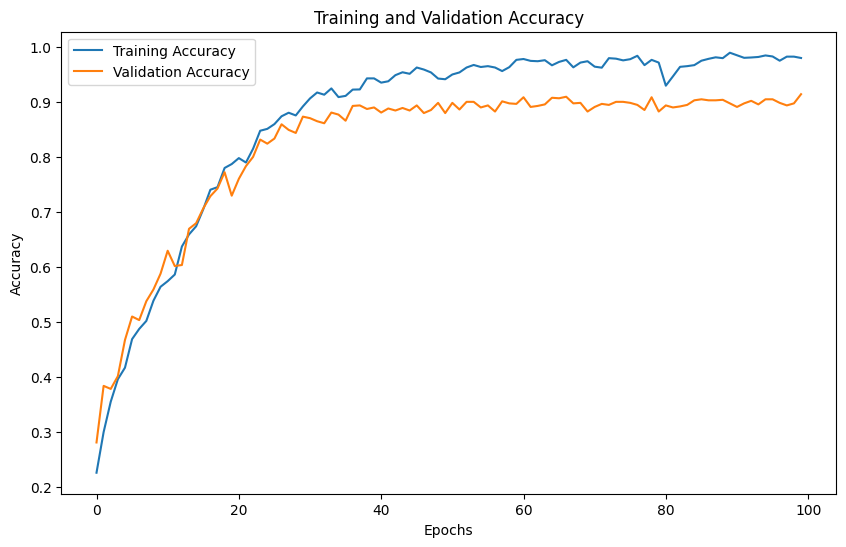

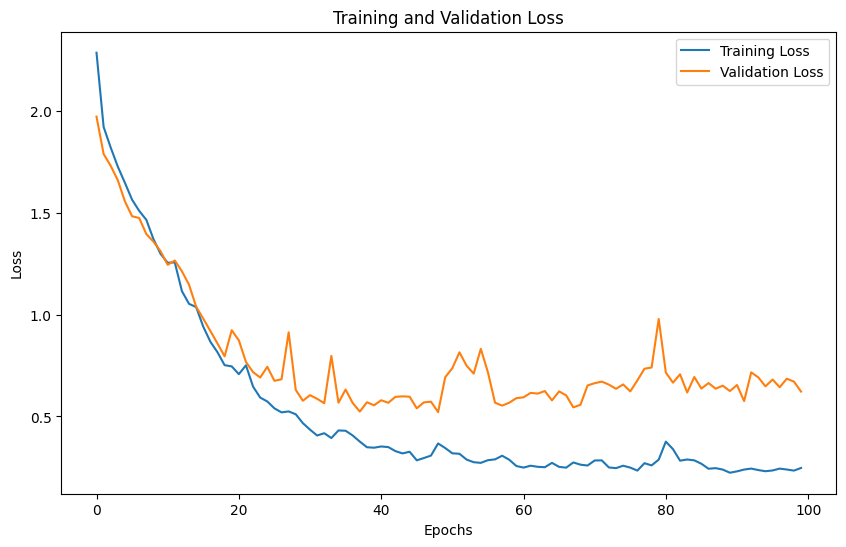

In [13]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluating Model Performance on Test Set

In [14]:
# Predict on test set
y_pred = model.predict(XTestProcessed)
y_pred_class = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_class))

34/34 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       140
           1       0.96      0.92      0.94       145
           2       0.90      0.89      0.89       149
           3       0.94      0.90      0.92       147
           4       0.91      0.97      0.94       159
           5       0.87      0.87      0.87        60
           6       0.91      0.90      0.90       132
           7       0.87      0.88      0.87       148

    accuracy                           0.91      1080
   macro avg       0.91      0.91      0.91      1080
weighted avg       0.91      0.91      0.91      1080



# Saving the Model, Architecture, and Weights

In [15]:
# Save the entire model to a single HDF5 file (already in your code)
model.save("SER.h5")

# Save the model architecture (JSON format)
model_json = model.to_json()
with open("SER.json", 'w') as json_file:
    json_file.write(model_json)

# Save the model weights separately (HDF5 format)
model.save_weights("SER.h5")


# Model Loading and Prediction

In [16]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from the JSON file
with open("SER.json", 'r') as json_file:
    model_json = json_file.read()

# Create the model from the JSON architecture
loaded_model = model_from_json(model_json)

# Load the model weights from the HDF5 file
loaded_model.load_weights("SER.h5")

# Now the model is ready for prediction
# Function to extract features from an audio file
def extract_feature_from_file(file_path, sr, mfcc, chroma, mel):
    data, sr = librosa.load(file_path)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    return feature

# Load an audio file and extract features
test_file_path = "C:\\Users\\muham\\Downloads\\Muarij\SER\\RAVDESS Dataset\\archive\\audio_speech_actors_01-24\\Actor_16\\03-01-08-01-02-02-16.wav"
test_feature = extract_feature_from_file(test_file_path, 22050, mfcc=True, chroma=True, mel=True)

# Prepare the feature for prediction
test_feature = np.expand_dims(test_feature, axis=0)
test_feature = np.expand_dims(test_feature, axis=2)

# Make a prediction
prediction = loaded_model.predict(test_feature)

# Convert the prediction to a class label
predicted_class = np.argmax(prediction, axis=1)[0]

# Map the class label to an emotion
emotion = list(le_name_mapping.keys())[list(le_name_mapping.values()).index(predicted_class)]

print(f"Predicted Emotion: {emotion}")


1/1 [==============================] - 0s 268ms/step
Predicted Emotion: surprised
